### Resumo

Este trabalho tem como objetivo desenvolver modelos de previsão de preços de criptomoedas, com foco na utilização de algoritmos de aprendizado de máquina. Serão implementadas e comparadas duas abordagens principais: uma rede neural recorrente do tipo LSTM (Long Short-Term Memory) e o algoritmo XGBoost (Extreme Gradient Boosting).

A pesquisa envolve o pré-processamento de dados, modelagem, ajuste de hiperparâmetros e avaliação de desempenho por meio de métricas estatísticas, como MAE, RMSE, MAPE e R². Os modelos serão utilizados para prever o preço da criptomoeda para o dia seguinte e para um horizonte de 30 dias à frente, permitindo analisar sua capacidade de generalização e precisão em diferentes prazos de previsão.

### 1. Introdução

Nesta seção é apresentada a motivação do estudo, o contexto do mercado de criptomoedas e a relevância da previsão de preços neste cenário.  
Também são descritos os objetivos gerais e específicos do trabalho, bem como a metodologia adotada.  

### 2. Fundamentação Teórica

Aqui são abordados os conceitos principais que sustentam o trabalho:

- Séries temporais e suas características

- Conceitos de aprendizado de máquina e redes neurais

- Estrutura e funcionamento das redes LSTM

- Algoritmo XGBoost e sua aplicação em previsão

### 3. Metodologia

Esta seção descreve as etapas do desenvolvimento do modelo, desde a obtenção e preparação dos dados até a avaliação dos resultados.


#### 3.1 Importação das Bibliotecas

In [263]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from scikeras.wrappers import KerasRegressor

from keras.models import Sequential
from keras.layers import Input, LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping
from keras.metrics import RootMeanSquaredError

#### 3.2 Carregamento e Ajuste dos Dados
Os dados foram coletados do yahoo finance em um periodo diário, os dados possuem as variaveis 'Close', 'High', 'Low', 'Open', 'Volume', 'Price'.<br>
Foi realizado ajuste no tipo dos dados e verificação de valores nulos ou duplicados.

In [264]:
data = pd.read_csv('./data/raw/BTC-USD.csv')
data = data.iloc[2:,:]
data.head(5)

,Price,Close,High,Low,Open,Volume
2,2014-09-17,457.3340148925781,468.17401123046875,452.4219970703125,465.864013671875,21056800
3,2014-09-18,424.44000244140625,456.8599853515625,413.10400390625,456.8599853515625,34483200
4,2014-09-19,394.7959899902344,427.8349914550781,384.5320129394531,424.1029968261719,37919700
5,2014-09-20,408.90399169921875,423.2959899902344,389.88299560546875,394.6730041503906,36863600
6,2014-09-21,398.8210144042969,412.4259948730469,393.1809997558594,408.0849914550781,26580100


In [265]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4054 entries, 2 to 4055
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Price   4054 non-null   object
 1   Close   4054 non-null   object
 2   High    4054 non-null   object
 3   Low     4054 non-null   object
 4   Open    4054 non-null   object
 5   Volume  4054 non-null   object
dtypes: object(6)
memory usage: 190.2+ KB


In [266]:
cols = ['Close', 'High', 'Low', 'Open', 'Volume']
data[cols] = data[cols].apply(pd.to_numeric, errors='coerce')
data.dtypes

Price      object
Close     float64
High      float64
Low       float64
Open      float64
Volume      int64
dtype: object

Apliquei a função pd.to_numeric em cada uma dessas colunas que converte os valores pra número (float ou int)<br>
Se algum valor não puder ser convertido (por exemplo, "ABC", "?", "-"), o parâmetro errors='coerce' manda ele transformar em NaN (valor nulo)

In [267]:
data = data.rename(columns={'Price': 'Date'})
data['Date'] = pd.to_datetime(data['Date'])
data.dtypes

Date      datetime64[ns]
Close            float64
High             float64
Low              float64
Open             float64
Volume             int64
dtype: object

In [268]:
data = data.set_index('Date')
data = data.sort_index()
data.head(5)


,Close,High,Low,Open,Volume
Date,,,,,
2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800
2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200
2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700
2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600
2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100


Agora já ajustei o nome da coluna, transformei para data, coloquei a data como indice do meu dataset e ordenei por garantia, porque vi que a ordem era importante para uma LSTM

Aqui criarei novas colunas representando o lag

In [269]:
n_steps = 30
for time_step in range(1, n_steps+1):
    data['closeLag_'+str(time_step)] = data['Close'].shift(time_step)

In [270]:
data = data.dropna()
data.isna().sum()
data = data.loc['2017-01-01':]
limite = data['Volume'].quantile(0.999)
data = data[data['Volume'] <= limite]

In [271]:
data[data.duplicated() == True]

,Close,High,Low,Open,Volume,closeLag_1,closeLag_2,closeLag_3,closeLag_4,closeLag_5,...,closeLag_21,closeLag_22,closeLag_23,closeLag_24,closeLag_25,closeLag_26,closeLag_27,closeLag_28,closeLag_29,closeLag_30
Date,,,,,,,,,,,,,,,,,,,,,


In [272]:
data.head(15)

,Close,High,Low,Open,Volume,closeLag_1,closeLag_2,closeLag_3,closeLag_4,closeLag_5,...,closeLag_21,closeLag_22,closeLag_23,closeLag_24,closeLag_25,closeLag_26,closeLag_27,closeLag_28,closeLag_29,closeLag_30
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,998.325012,1003.080017,958.698975,963.658020,147775008,963.742981,961.237976,973.497009,975.921021,933.197998,...,769.731018,774.650024,772.794006,770.809998,768.132019,764.223999,758.700012,773.872009,771.155029,777.943970
2017-01-02,1021.750000,1031.390015,996.702026,998.617004,222184992,998.325012,963.742981,961.237976,973.497009,975.921021,...,780.086975,769.731018,774.650024,772.794006,770.809998,768.132019,764.223999,758.700012,773.872009,771.155029
2017-01-03,1043.839966,1044.079956,1021.599976,1021.599976,185168000,1021.750000,998.325012,963.742981,961.237976,973.497009,...,780.556030,780.086975,769.731018,774.650024,772.794006,770.809998,768.132019,764.223999,758.700012,773.872009
2017-01-04,1154.729980,1159.420044,1044.400024,1044.400024,344945984,1043.839966,1021.750000,998.325012,963.742981,961.237976,...,781.481018,780.556030,780.086975,769.731018,774.650024,772.794006,770.809998,768.132019,764.223999,758.700012
2017-01-05,1013.380005,1191.099976,910.416992,1156.729980,510199008,1154.729980,1043.839966,1021.750000,998.325012,963.742981,...,778.088013,781.481018,780.556030,780.086975,769.731018,774.650024,772.794006,770.809998,768.132019,764.223999
2017-01-06,902.200989,1046.810059,883.943970,1014.239990,351876000,1013.380005,1154.729980,1043.839966,1021.750000,998.325012,...,784.906982,778.088013,781.481018,780.556030,780.086975,769.731018,774.650024,772.794006,770.809998,768.132019
2017-01-07,908.585022,908.585022,823.556030,903.487000,279550016,902.200989,1013.380005,1154.729980,1043.839966,1021.750000,...,790.828979,784.906982,778.088013,781.481018,780.556030,780.086975,769.731018,774.650024,772.794006,770.809998
2017-01-08,911.198975,942.723999,887.249023,908.174988,158715008,908.585022,902.200989,1013.380005,1154.729980,1043.839966,...,790.530029,790.828979,784.906982,778.088013,781.481018,780.556030,780.086975,769.731018,774.650024,772.794006
2017-01-09,902.828003,913.685974,879.807007,913.244019,141876992,911.198975,908.585022,902.200989,1013.380005,1154.729980,...,792.713989,790.530029,790.828979,784.906982,778.088013,781.481018,780.556030,780.086975,769.731018,774.650024


In [273]:
data.to_csv('./data/results/BTC-USD.csv', index=True)

#### 3.3 Explorando Dados
Nessa seção buscamos apenas entender um pouco melhor os dados.

In [274]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Close,3213.0,3.216734e+04,3.108090e+04,7.777570e+02,7.927714e+03,2.086045e+04,4.768681e+04,1.247525e+05
High,3213.0,3.278576e+04,3.156319e+04,8.233070e+02,8.138414e+03,2.136112e+04,4.896937e+04,1.261981e+05
Low,3213.0,3.144974e+04,3.051899e+04,7.557560e+02,7.705500e+03,2.041506e+04,4.669020e+04,1.231960e+05
Open,3213.0,3.213202e+04,3.104958e+04,7.751780e+02,7.925434e+03,2.083410e+04,4.768003e+04,1.247521e+05
Volume,3213.0,2.621612e+10,2.086756e+10,6.085170e+07,9.999172e+09,2.289539e+10,3.659944e+10,1.336733e+11
closeLag_1,3213.0,3.213071e+04,3.104881e+04,7.777570e+02,7.923645e+03,2.083633e+04,4.767212e+04,1.247525e+05
closeLag_2,3213.0,3.209731e+04,3.102577e+04,7.777570e+02,7.916880e+03,2.081848e+04,4.758886e+04,1.247525e+05
closeLag_3,3213.0,3.206408e+04,3.100159e+04,7.777570e+02,7.911430e+03,2.077934e+04,4.750485e+04,1.247525e+05
closeLag_4,3213.0,3.202789e+04,3.097326e+04,7.777570e+02,7.909729e+03,2.077044e+04,4.746573e+04,1.235135e+05
closeLag_5,3213.0,3.199588e+04,3.095441e+04,7.777570e+02,7.902090e+03,2.073548e+04,4.734522e+04,1.247525e+05


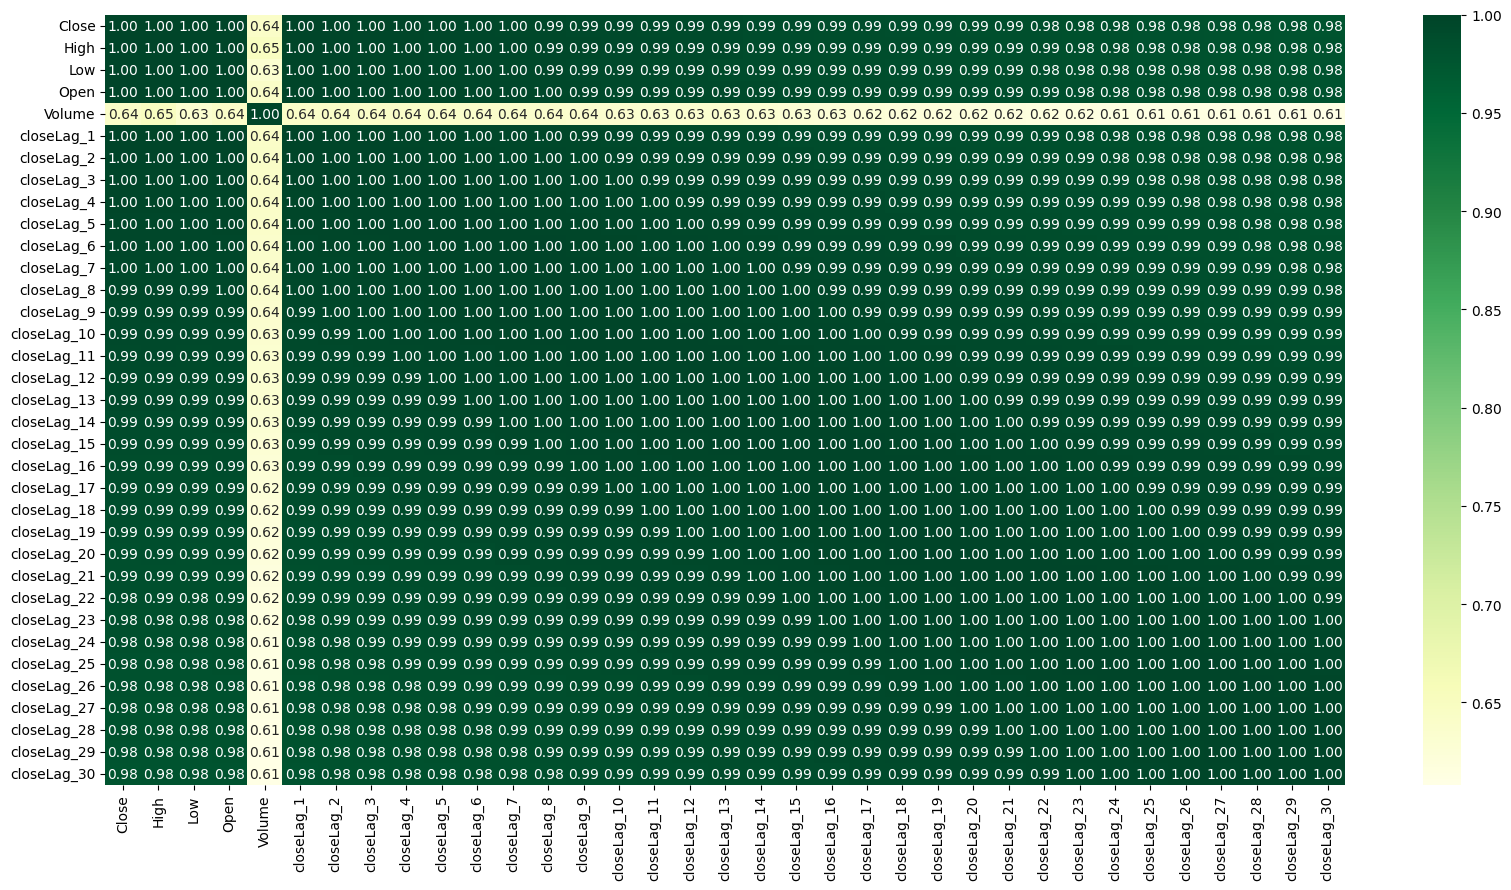

In [275]:
plt.figure(figsize=(20, 10)) 
sns.heatmap(data.corr(), annot=True, cmap="YlGn", fmt=".2f")
plt.show()

In [276]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)
data_scaled = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)

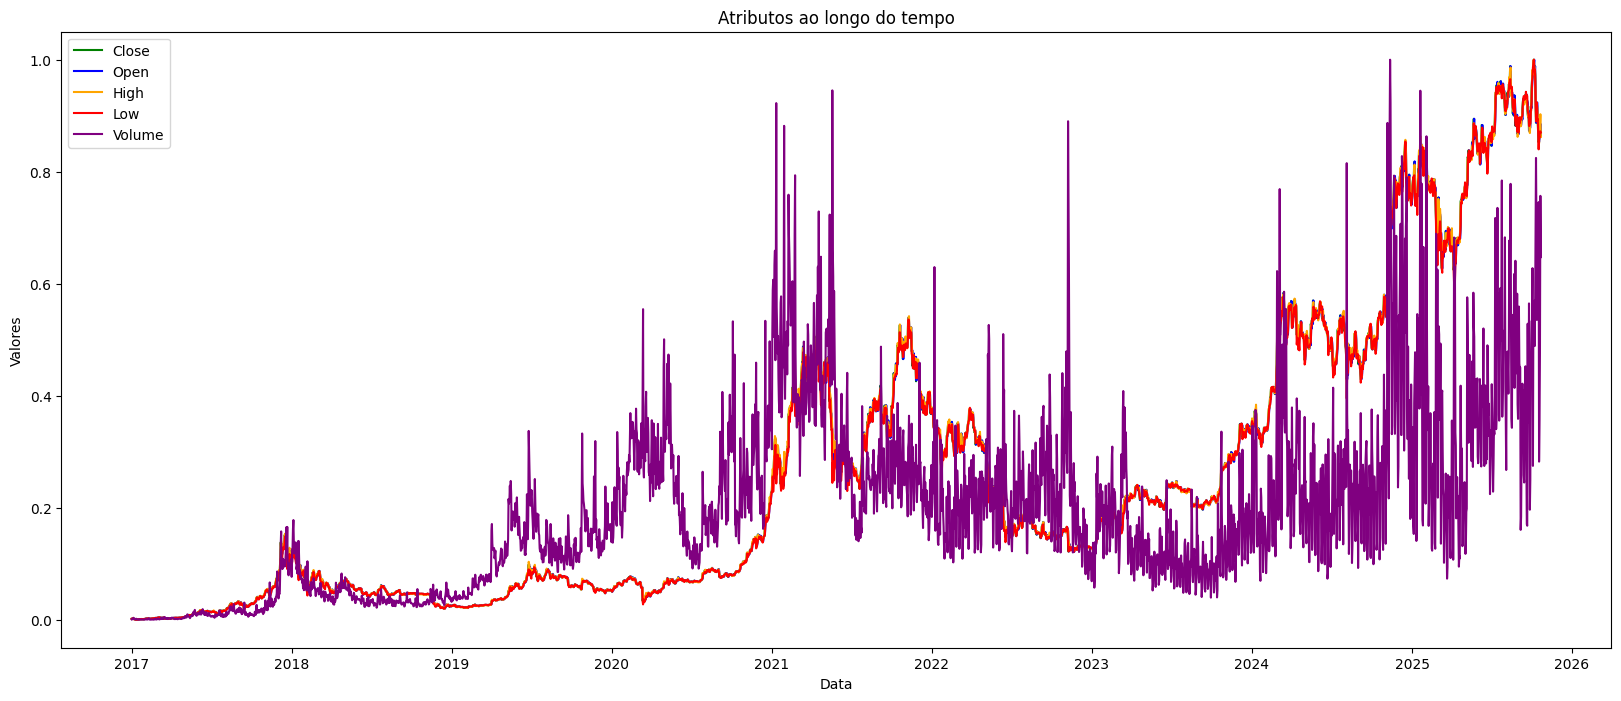

In [ ]:
plt.figure(figsize=(20,8))

plt.plot(data_scaled.index, data_scaled['Volume'], label='Volume', color='purple')
plt.plot(data_scaled.index, data_scaled['Close'], label='Close', color='green')
plt.plot(data_scaled.index, data_scaled['Open'], label='Open', color='blue')
plt.plot(data_scaled.index, data_scaled['High'], label='High', color='orange')
plt.plot(data_scaled.index, data_scaled['Low'], label='Low', color='red')

plt.title('Atributos ao longo do tempo')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.show()

podemos notar que close, open, high e low possuem praticamente a mesma tendencia como acusado pela matriz de correlação, já o volume tem o comportamento diferente, com picos e quedas meio bruscas

#### 3.4 Predição Dia Seguinte

In [278]:
def create_sequences_uni(data=[], seq_len=7):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

In [279]:
def create_sequences_mult(X, y, seq_len=14):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])   
        ys.append(y[i+seq_len])    
    return np.array(Xs), np.array(ys)

In [280]:
serie_uni = data['Close']

train_size = int(0.8 * len(serie_uni))
train_data_uni = serie_uni[:train_size].values.reshape(-1, 1)
test_data_uni = serie_uni[train_size:].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0,1))
data_uni_train_scaled = scaler.fit_transform(train_data_uni)
data_uni_test_scaled = scaler.transform(test_data_uni)

In [281]:
X_mult = data[['High', 'Low', 'Open', 'Volume']]
y_mult = data[['Close']]

scaler_X = MinMaxScaler(feature_range=(0,1))
scaler_y = MinMaxScaler(feature_range=(0,1))

X_mult_scaled = scaler_X.fit_transform(X_mult)
y_mult_scaled = scaler_y.fit_transform(y_mult)

In [282]:
models_lstm = []
models_xgb = []
seq_len_options = [7, 14, 30]
split_options = [5, 10]

##### 3.4.1 LSTM (Long Short Term Memory)

In [283]:
def create_lstm_model(seq_len=14, n_features=1, neurons=100, drop=0.2, optimizer='Adam'):
  model = Sequential([
      Input(shape=(seq_len, n_features)),
      LSTM(neurons, return_sequences=True),
      Dropout(drop),
      LSTM((neurons//2), return_sequences=False),
      Dropout(drop),
      Dense(1),
  ])
  model.compile(optimizer=optimizer, loss='mse', metrics=[RootMeanSquaredError()])
  return model


param_grid = {
                'model__neurons': [16, 32, 64],
                'model__drop': [0.2, 0.25, 0.3],
                'model__optimizer': ['Adam'], 
                'fit__batch_size': [16, 32],   
                'fit__epochs': [50, 100]
                # 'model__neurons': [16],
                # 'model__drop': [0.2],
                # 'model__optimizer': ['Adam'], 
                # 'fit__batch_size': [16],   
                # 'fit__epochs': [100],
              }

###### 3.4.1.1 Modelo Univariado

In [284]:
for seq_len in seq_len_options:
  print(f"===== JANELA DE {seq_len} =====")

  X_train_scaled, y_train_scaled = create_sequences_uni(data_uni_train_scaled, seq_len)
  X_test_scaled, y_test_scaled = create_sequences_uni(data_uni_test_scaled, seq_len)

  for split in split_options:
    print(f"_____ SPLIT DE {split} _____")

    model = KerasRegressor(model=create_lstm_model, verbose=0, seq_len=seq_len, n_features=X_train_scaled.shape[2])

    tscv = TimeSeriesSplit(n_splits=split)

    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, refit=True, scoring="neg_root_mean_squared_error", n_jobs = -1)

    early_stopping = EarlyStopping(monitor='val_root_mean_squared_error', patience=10, restore_best_weights=True)

    grid_result = grid.fit(X_train_scaled, y_train_scaled, callbacks=[early_stopping], validation_split=0.2)

    models_lstm.append({
      "params": grid_result.best_params_,
      "rmse": -grid_result.best_score_,
      "n_splits": split,
      "seq_len": seq_len,
      "type": "Univariado",
      "algorithm": "LSTM"
    })
    
    print(f"Menor RMSE: {-grid_result.best_score_:.3f} usando: {grid_result.best_params_}")

===== JANELA DE 7 =====
_____ SPLIT DE 5 _____
Menor RMSE: 0.023 usando: {'fit__batch_size': 32, 'fit__epochs': 100, 'model__drop': 0.2, 'model__neurons': 64, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.023 usando: {'fit__batch_size': 32, 'fit__epochs': 100, 'model__drop': 0.25, 'model__neurons': 64, 'model__optimizer': 'Adam'}
===== JANELA DE 14 =====
_____ SPLIT DE 5 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.025 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.25, 'model__neurons': 64, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.020 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.25, 'model__neurons': 64, 'model__optimizer': 'Adam'}
===== JANELA DE 30 =====
_____ SPLIT DE 5 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.020 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.2, 'model__neurons': 64, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.023 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.2, 'model__neurons': 64, 'model__optimizer': 'Adam'}


###### 3.4.1.2 Modelo Multivariado

In [285]:
for seq_len in seq_len_options:
  print(f"===== JANELA DE {seq_len} =====")

  X_seq, y_seq = create_sequences_mult(X_mult_scaled, y_mult_scaled, seq_len)

  train_size = int(0.8 * len(X_seq))

  X_train_scaled, X_test_scaled = X_seq[:train_size], X_seq[train_size:]
  y_train_scaled, y_test_scaled = y_seq[:train_size], y_seq[train_size:]

  for split in split_options:
    print(f"_____ SPLIT DE {split} _____")

    model = KerasRegressor(model=create_lstm_model, verbose=0, seq_len=seq_len, n_features=X_train_scaled.shape[2])

    tscv = TimeSeriesSplit(n_splits=split)

    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, refit=True, scoring="neg_root_mean_squared_error", n_jobs = -1)

    early_stopping = EarlyStopping(monitor='val_root_mean_squared_error', patience=10, restore_best_weights=True)

    grid_result = grid.fit(X_train_scaled, y_train_scaled, callbacks=[early_stopping], validation_split=0.2)

    models_lstm.append({
      "params": grid_result.best_params_,
      "rmse": -grid_result.best_score_,
      "n_splits": split,
      "seq_len": seq_len,
      "type": "Multivariado",
      "algorithm": "LSTM"
    })
    
    print(f"Menor RMSE: {-grid_result.best_score_:.3f} usando: {grid_result.best_params_}")

===== JANELA DE 7 =====
_____ SPLIT DE 5 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.014 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.2, 'model__neurons': 64, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.012 usando: {'fit__batch_size': 32, 'fit__epochs': 100, 'model__drop': 0.2, 'model__neurons': 64, 'model__optimizer': 'Adam'}
===== JANELA DE 14 =====
_____ SPLIT DE 5 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.016 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.2, 'model__neurons': 64, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.013 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.2, 'model__neurons': 64, 'model__optimizer': 'Adam'}
===== JANELA DE 30 =====
_____ SPLIT DE 5 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.017 usando: {'fit__batch_size': 32, 'fit__epochs': 100, 'model__drop': 0.2, 'model__neurons': 64, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.015 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.25, 'model__neurons': 64, 'model__optimizer': 'Adam'}


###### 3.4.1.3 Resultados e Discussão

Nesta seção são apresentados e discutidos os resultados obtidos pelos modelos.
Comente sobre o desempenho de cada configuração de parâmetros e interprete as métricas.  
Apresente também comparações gráficas entre valores reais e previstos.


In [286]:
ordered_models = sorted(models_lstm, key=lambda x: x["rmse"])
ordered_models

[{'params': {'fit__batch_size': 32,
   'fit__epochs': 100,
   'model__drop': 0.2,
   'model__neurons': 64,
   'model__optimizer': 'Adam'},
  'rmse': np.float64(0.012217439053305133),
  'n_splits': 10,
  'seq_len': 7,
  'type': 'Multivariado',
  'algorithm': 'LSTM'},
 {'params': {'fit__batch_size': 16,
   'fit__epochs': 100,
   'model__drop': 0.2,
   'model__neurons': 64,
   'model__optimizer': 'Adam'},
  'rmse': np.float64(0.013368500149900406),
  'n_splits': 10,
  'seq_len': 14,
  'type': 'Multivariado',
  'algorithm': 'LSTM'},
 {'params': {'fit__batch_size': 16,
   'fit__epochs': 100,
   'model__drop': 0.2,
   'model__neurons': 64,
   'model__optimizer': 'Adam'},
  'rmse': np.float64(0.01407165557817348),
  'n_splits': 5,
  'seq_len': 7,
  'type': 'Multivariado',
  'algorithm': 'LSTM'},
 {'params': {'fit__batch_size': 16,
   'fit__epochs': 100,
   'model__drop': 0.25,
   'model__neurons': 64,
   'model__optimizer': 'Adam'},
  'rmse': np.float64(0.01467013501352259),
  'n_splits': 10,

In [287]:
grid_result.best_estimator_

,model,<function cre...001A204581EE0>
,build_fn,None
,warm_start,False
,random_state,None
,optimizer,'rmsprop'
,loss,None
,metrics,None
,batch_size,None
,validation_batch_size,None
,verbose,0
,callbacks,None


In [288]:
y_pred_scaled = grid_result.best_estimator_.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test_scaled, y_pred_scaled))
mae = mean_absolute_error(y_test_scaled, y_pred_scaled)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test = scaler_y.inverse_transform(y_test_scaled)


MAE: 0.047246556804285494
RMSE: 0.05791878027940451


In [289]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

mae_percent = (mae / len(y_test)) * 100
rmse_percent = (rmse / len(y_test)) * 100
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"MAE(%): {mae_percent:.2f}%")
print(f"RMSE(%): {rmse_percent:.2f}%")
print(f"MAPE(%): {mape:.2f}%")

MAE: 5857.381524725275
RMSE: 7180.468072436347
MAE(%): 919.53%
RMSE(%): 1127.23%
MAPE(%): 6.31%


In [290]:
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2:.2f}")


R²: 0.89


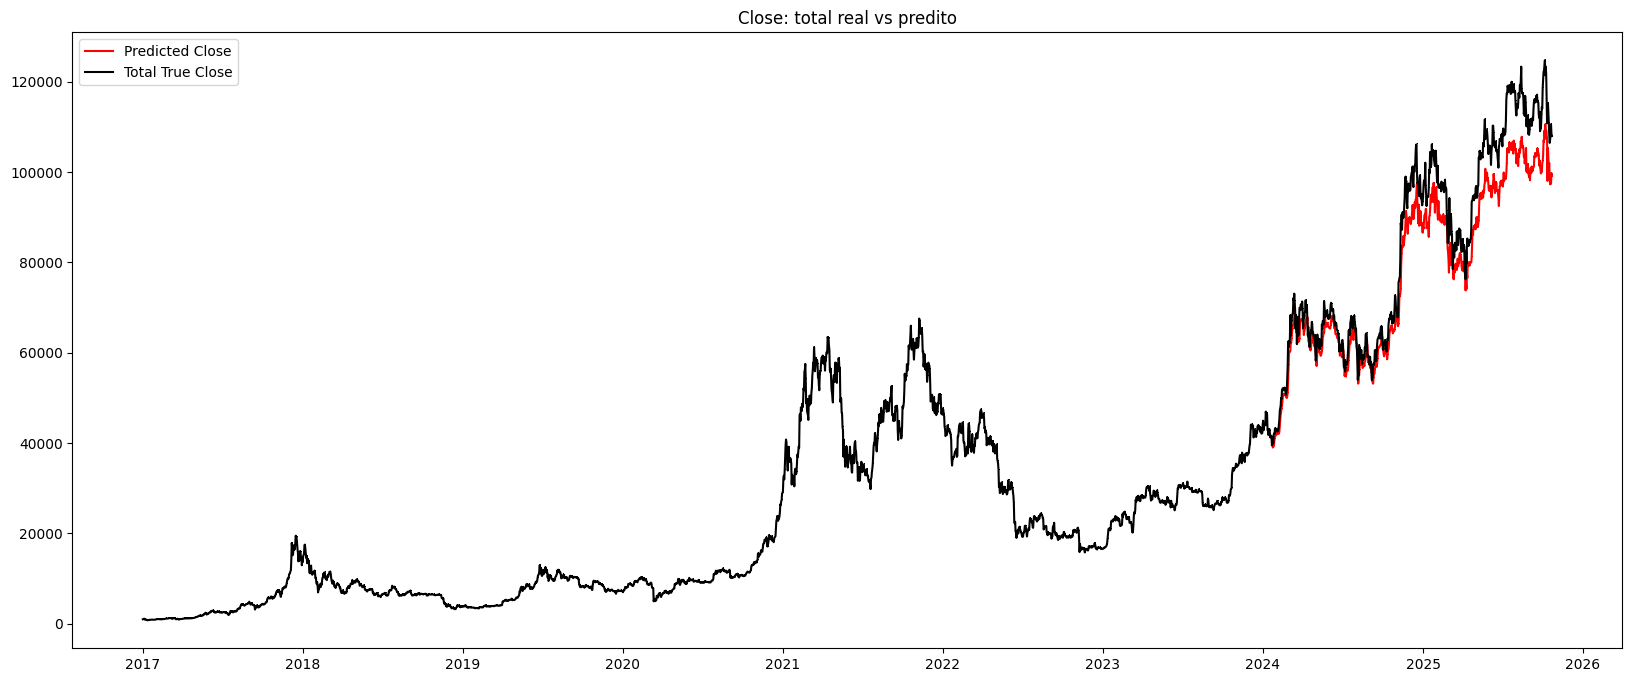

In [291]:
y_pred_plot = np.empty_like(data['Close'])
y_pred_plot[:] = np.nan
y_pred_plot[-len(y_pred):] = y_pred.reshape(-1)

plt.figure(figsize=(20,8))
plt.plot(data.index, y_pred_plot, color="red", marker=",", label='Predicted Close')
plt.plot(data.index, np.array(data['Close']), color="black", marker=",", label='Total True Close')
plt.title('Close: total real vs predito')
plt.legend()
plt.show()

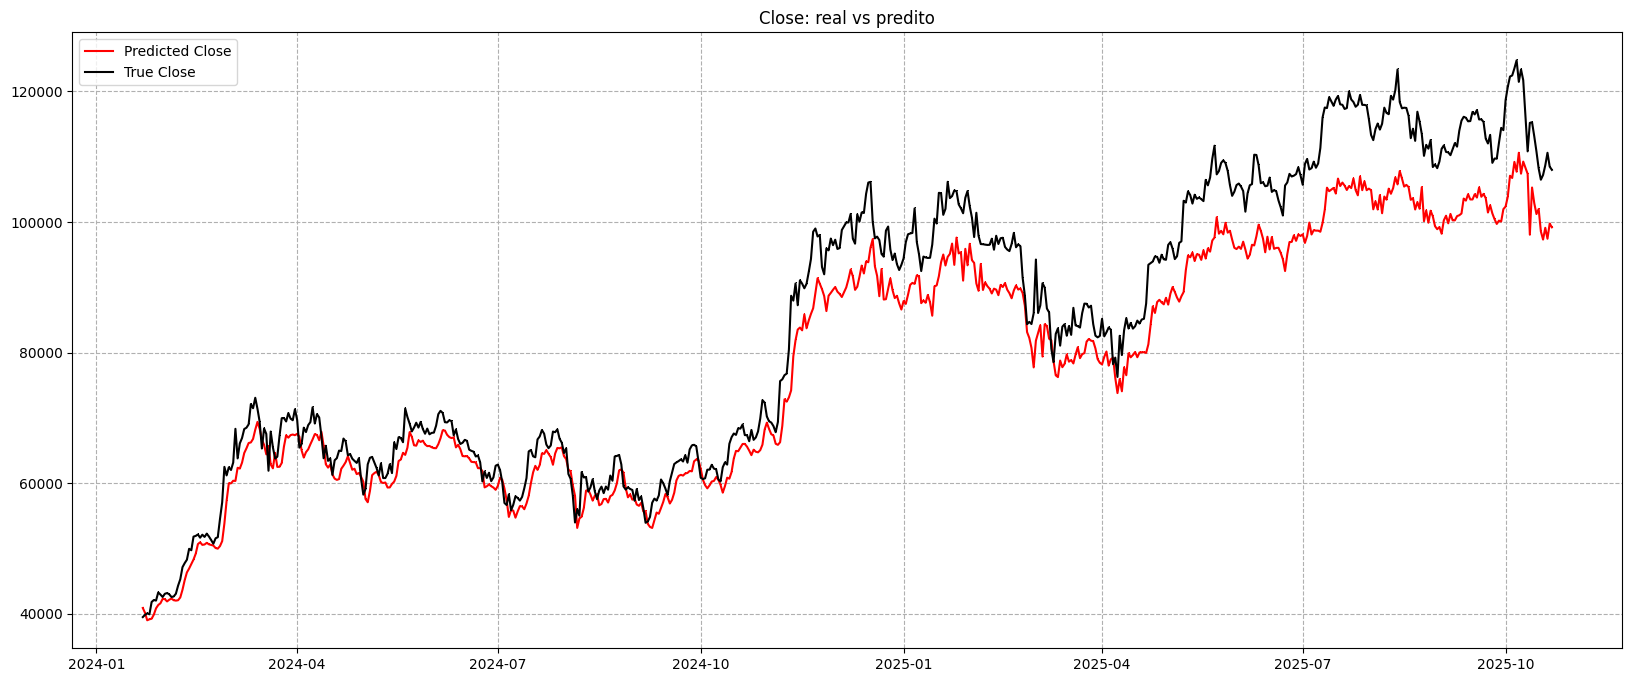

In [292]:

plt.figure(figsize=(20,8))
plt.plot(data.index[-len(y_pred):], y_pred, color="red", marker=",", label='Predicted Close')
plt.plot(data.index[-len(y_test):], y_test, color="black", marker=",", label='True Close')
plt.title('Close: real vs predito')
plt.legend()
plt.grid(True, linestyle="--")
plt.show()

##### 3.4.2 XGB (XGBoost)

In [293]:
param_grid = {
    'n_estimators': [200, 400, 600, 800, 1000],           
    'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25],        
    'max_depth': [3, 4, 6],   
}

###### 3.4.2.1 Modelo Univariado

In [294]:
for seq_len in seq_len_options:
  print(f"===== JANELA DE {seq_len} =====")

  X_train_scaled, y_train_scaled = create_sequences_uni(data_uni_train_scaled, seq_len)
  X_test_scaled, y_test_scaled = create_sequences_uni(data_uni_test_scaled, seq_len)

  n_samples_train = X_train_scaled.shape[0]
  X_train_flat = X_train_scaled.reshape(n_samples_train, -1)


  for split in split_options:
    print(f"_____ SPLIT DE {split} _____")

    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, eval_metric='mae')

    tscv = TimeSeriesSplit(n_splits=split)

    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1, refit=True)

    grid_result = grid.fit(X_train_flat, y_train_scaled)

    models_xgb.append({
      "params": grid_result.best_params_,
      "rmse": -grid_result.best_score_,
      "n_splits": split,
      "seq_len": seq_len,
      "type": "Univariado",
      "algorithm": "XGB"
    })
    
    print(f"Menor RMSE: {-grid_result.best_score_:.3f} usando: {grid_result.best_params_}")

===== JANELA DE 7 =====
_____ SPLIT DE 5 _____
Menor RMSE: 0.081 usando: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
_____ SPLIT DE 10 _____
Menor RMSE: 0.062 usando: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
===== JANELA DE 14 =====
_____ SPLIT DE 5 _____
Menor RMSE: 0.083 usando: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
_____ SPLIT DE 10 _____
Menor RMSE: 0.063 usando: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
===== JANELA DE 30 =====
_____ SPLIT DE 5 _____
Menor RMSE: 0.084 usando: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
_____ SPLIT DE 10 _____
Menor RMSE: 0.066 usando: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


###### 3.4.2.2 Modelo Multivariado

In [295]:
for seq_len in seq_len_options:
  print(f"===== JANELA DE {seq_len} =====")

  X_seq, y_seq = create_sequences_mult(X_mult_scaled, y_mult_scaled, seq_len)

  train_size = int(0.8 * len(X_seq))

  X_train_scaled, X_test_scaled = X_seq[:train_size], X_seq[train_size:]
  y_train_scaled, y_test_scaled = y_seq[:train_size], y_seq[train_size:]
  
  n_samples_train = X_train_scaled.shape[0]
  X_train_flat = X_train_scaled.reshape(n_samples_train, -1)

  for split in split_options:
    print(f"_____ SPLIT DE {split} _____")

    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, eval_metric='mae')

    tscv = TimeSeriesSplit(n_splits=split)

    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1, refit=True)

    grid_result = grid.fit(X_train_flat, y_train_scaled)

    models_xgb.append({
      "params": grid_result.best_params_,
      "rmse": -grid_result.best_score_,
      "n_splits": split,
      "seq_len": seq_len,
      "type": "Univariado",
      "algorithm": "XGB"
    })
    
    print(f"Menor RMSE: {-grid_result.best_score_:.3f} usando: {grid_result.best_params_}")

===== JANELA DE 7 =====
_____ SPLIT DE 5 _____
Menor RMSE: 0.044 usando: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
_____ SPLIT DE 10 _____
Menor RMSE: 0.034 usando: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
===== JANELA DE 14 =====
_____ SPLIT DE 5 _____
Menor RMSE: 0.047 usando: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
_____ SPLIT DE 10 _____
Menor RMSE: 0.036 usando: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
===== JANELA DE 30 =====
_____ SPLIT DE 5 _____
Menor RMSE: 0.049 usando: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
_____ SPLIT DE 10 _____
Menor RMSE: 0.038 usando: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}


###### 3.4.2.3 Resultados e Discussão

Nesta seção são apresentados e discutidos os resultados obtidos pelos modelos.
Comente sobre o desempenho de cada configuração de parâmetros e interprete as métricas.  
Apresente também comparações gráficas entre valores reais e previstos.


In [296]:
ordered_models = sorted(models_xgb, key=lambda x: x["rmse"])
ordered_models

[{'params': {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200},
  'rmse': np.float64(0.03416455956233615),
  'n_splits': 10,
  'seq_len': 7,
  'type': 'Univariado',
  'algorithm': 'XGB'},
 {'params': {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200},
  'rmse': np.float64(0.035899182437728695),
  'n_splits': 10,
  'seq_len': 14,
  'type': 'Univariado',
  'algorithm': 'XGB'},
 {'params': {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200},
  'rmse': np.float64(0.038102483182531136),
  'n_splits': 10,
  'seq_len': 30,
  'type': 'Univariado',
  'algorithm': 'XGB'},
 {'params': {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200},
  'rmse': np.float64(0.04447707342917329),
  'n_splits': 5,
  'seq_len': 7,
  'type': 'Univariado',
  'algorithm': 'XGB'},
 {'params': {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200},
  'rmse': np.float64(0.046817677560648946),
  'n_splits': 5,
  'seq_len': 14,
  'type': 'Univariado',
  'algorithm': 'XGB'},
 {'para

In [297]:
grid_result.best_estimator_

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mae'


In [298]:
n_samples_test = X_test_scaled.shape[0]
X_test_flat = X_test_scaled.reshape(n_samples_test, -1)


y_pred_scaled = grid_result.best_estimator_.predict(X_test_flat)

rmse = np.sqrt(mean_squared_error(y_test_scaled, y_pred_scaled))
mae = mean_absolute_error(y_test_scaled, y_pred_scaled)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

y_pred_scaled_2d = y_pred_scaled.reshape(-1, 1)
y_test_scaled_2d = y_test_scaled.reshape(-1, 1)

y_pred = scaler_y.inverse_transform(y_pred_scaled_2d)
y_test = scaler_y.inverse_transform(y_test_scaled_2d)

MAE: 0.18752903119964767
RMSE: 0.24855055099268483


In [299]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

mae_percent = (mae / len(y_test)) * 100
rmse_percent = (rmse / len(y_test)) * 100
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"MAE(%): {mae_percent:.2f}%")
print(f"RMSE(%): {rmse_percent:.2f}%")
print(f"MAPE(%): {mape:.2f}%")

MAE: 23248.868904532967
RMSE: 30813.9980845915
MAE(%): 3649.74%
RMSE(%): 4837.36%
MAPE(%): 23.20%


In [300]:
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2:.2f}")


R²: -0.94


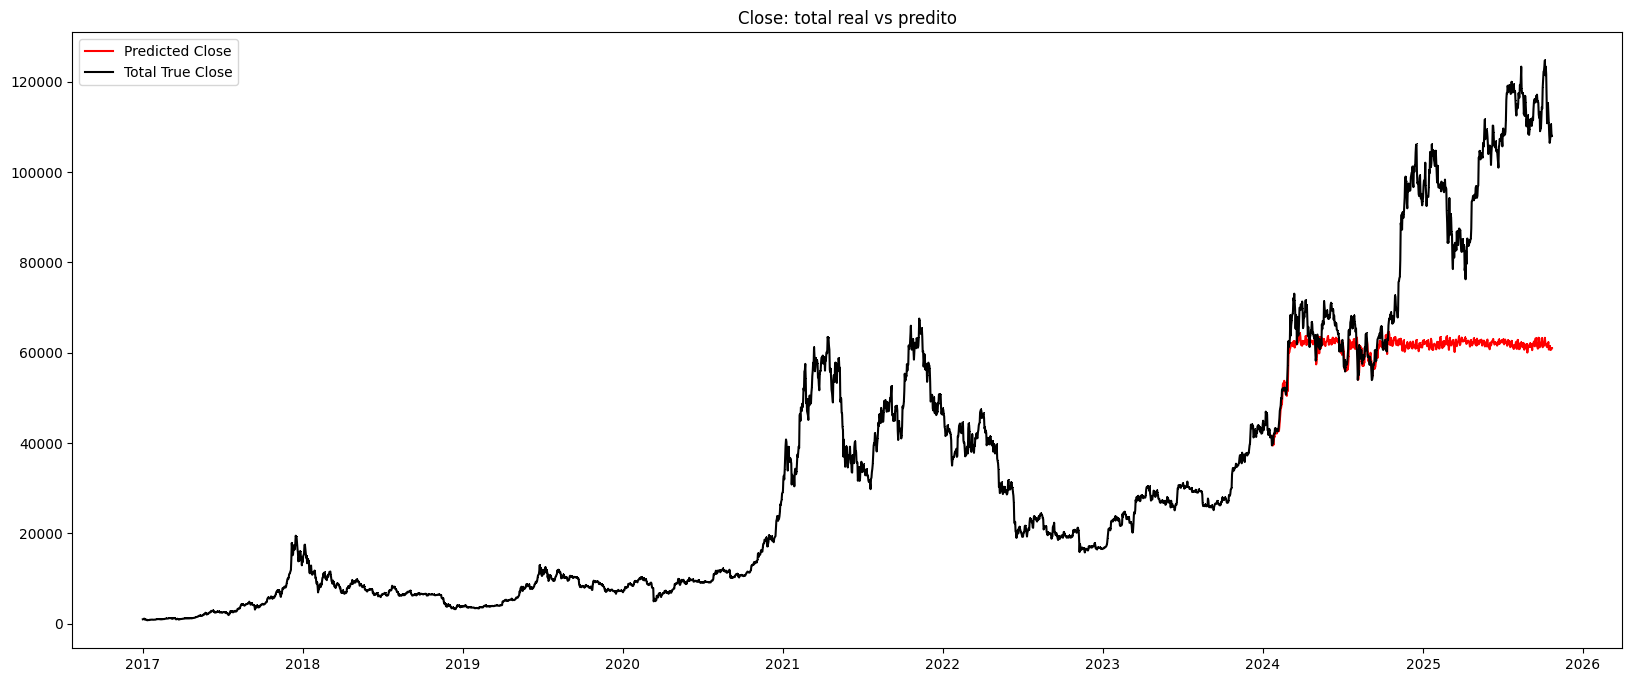

In [301]:
y_pred_plot = np.empty_like(data['Close'])
y_pred_plot[:] = np.nan
y_pred_plot[-len(y_pred):] = y_pred.reshape(-1)

plt.figure(figsize=(20,8))
plt.plot(data.index, y_pred_plot, color="red", marker=",", label='Predicted Close')
plt.plot(data.index, np.array(data['Close']), color="black", marker=",", label='Total True Close')
plt.title('Close: total real vs predito')
plt.legend()
plt.show()

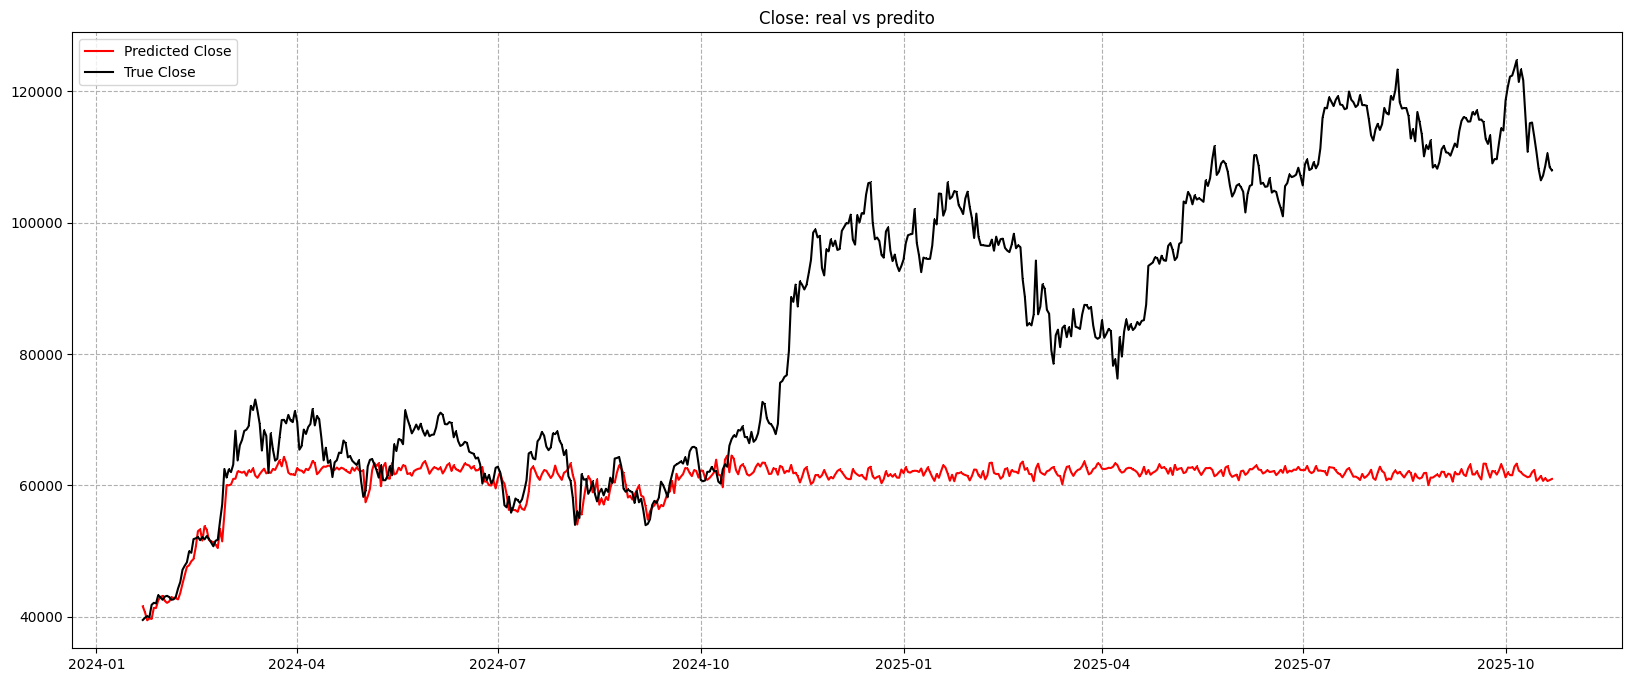

In [302]:
dias_analise=30

plt.figure(figsize=(20,8))
plt.plot(data.index[-len(y_pred):], y_pred, color="red", marker=",", label='Predicted Close')
plt.plot(data.index[-len(y_test):], y_test, color="black", marker=",", label='True Close')
plt.title('Close: real vs predito')
plt.legend()
plt.grid(True, linestyle="--")
plt.show()